In [19]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection
import supervision as sv
import os

In [20]:
def save_model(model, model_path):
    """Save the trained DETR model"""
    # Save the model weights and configuration
    model.model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

In [21]:
def load_model(model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Load the trained DETR model for inference"""

    # Load the model
    model = DetrForObjectDetection.from_pretrained(model_path)
    model.to(device)
    model.eval()  # Set to evaluation mode

    # Load the image processor
    image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    print(f"Model loaded from {model_path} on device: {device}")
    return model, image_processor

In [22]:
def detect_cars_in_image(image_path, model, image_processor, device, confidence_threshold=0.5):
    """
    Detect cars in a single image

    Args:
        image_path: Path to the image file
        model: Loaded DETR model
        image_processor: DETR image processor
        device: Device to run inference on
        confidence_threshold: Minimum confidence score for detections

    Returns:
        detections: Supervision detections object
        annotated_image: Image with bounding boxes drawn
    """

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt").to(device)

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert outputs to detections
    target_sizes = torch.tensor([image.size[::-1]]).to(device)  # (height, width)
    results = image_processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=confidence_threshold
    )[0]

    # Extract bounding boxes, scores, and labels
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"].cpu().numpy()

    # Convert to supervision format for visualization
    detections = sv.Detections(
        xyxy=boxes,
        confidence=scores,
        class_id=labels
    )

    # Annotate image
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Create labels with confidence scores
    labels_text = [f"car: {score:.2f}" for score in scores]

    annotated_image = box_annotator.annotate(scene=image_cv.copy(), detections=detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections,
        labels=labels_text
    )

    return detections, cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)


In [30]:
def run_inference_pipeline(image_path=None):
    """Complete example of loading model and running inference"""

    # Configuration
    MODEL_PATH = 'car-object-detection-detr-finetuned-with-validation-iter-2'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CONFIDENCE_THRESHOLD = 0.03

    # Load model
    model, image_processor = load_model(MODEL_PATH, DEVICE)

    # Example 1: Single image inference
    if image_path is None:
        image_path = "../data/testing_images/car_example.jpeg"  # Replace with actual path
    if os.path.exists(image_path):
        detections, annotated_image = detect_cars_in_image(
            image_path, model, image_processor, DEVICE, CONFIDENCE_THRESHOLD
        )

        # Display results
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.title(f'Detected {len(detections)} cars')
        plt.show()

        # Print detection details
        print(f"Number of cars detected: {len(detections)}")
        for i, (box, conf) in enumerate(zip(detections.xyxy, detections.confidence)):
            print(f"Car {i+1}: Bbox={box}, Confidence={conf:.3f}")

    # Example 2: Video inference (using the provided test video)
    video_path = "https://intip.in/QNpw"  # The demo video from requirements
    output_video_path = "car_detection_output.mp4"

    # Note: You'll need to download the video first or use a local video file
    # detect_cars_in_video(video_path, model, image_processor, DEVICE,
    #                     CONFIDENCE_THRESHOLD, output_video_path)

Model loaded from car-object-detection-detr-finetuned-with-validation-iter-2 on device: cpu


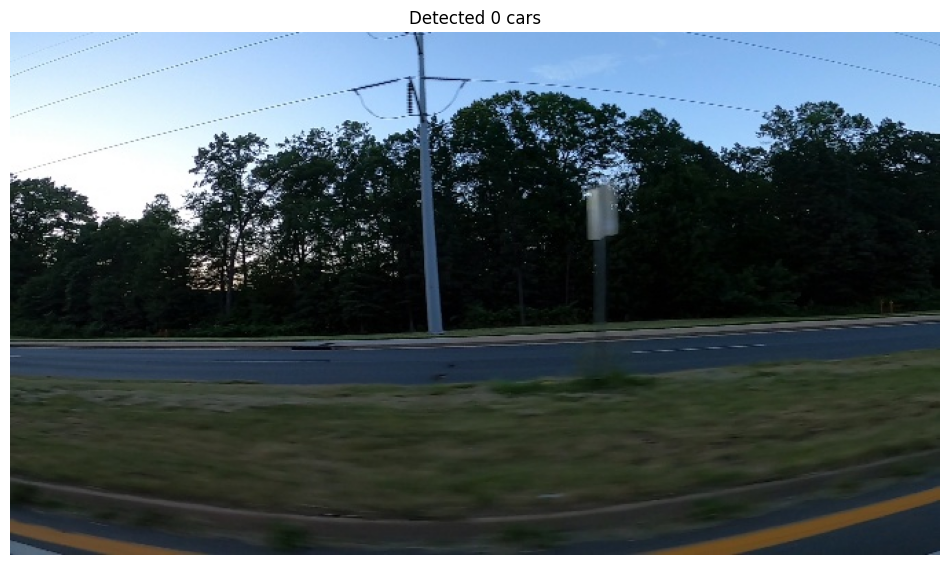

Number of cars detected: 0


In [31]:
run_inference_pipeline(
    image_path = '../data/testing_images/vid_5_25160.jpg'
)

Model loaded from car-object-detection-detr-finetuned-with-validation-iter-2 on device: cpu


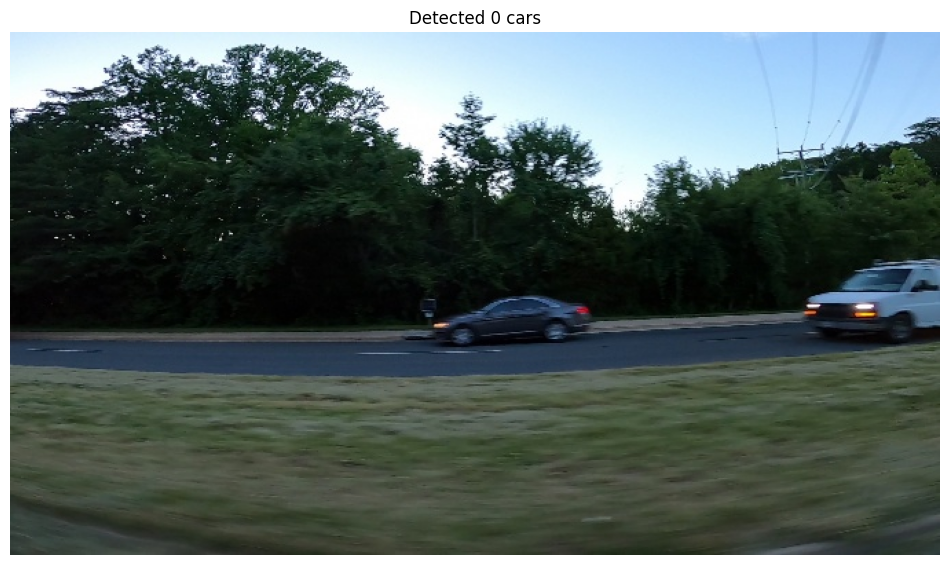

Number of cars detected: 0


In [32]:
run_inference_pipeline(
    image_path = '../data/testing_images/vid_5_26700.jpg'
)